# Simple VPIN Benchmark

Basic VPIN performance testing with different data sizes.

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import rust_indicators
from pycoingecko import CoinGeckoAPI
import time

cg = CoinGeckoAPI()
ta = rust_indicators.RustTA()
print(f"Backend: {ta.device()}")

Backend: cpu


In [2]:
# Generate test data
def generate_test_data(size):
    np.random.seed(42)
    returns = np.random.normal(0.0001, 0.02, size)
    prices = 50000 * np.exp(np.cumsum(returns))
    
    volatility = np.abs(returns)
    volumes = 1e9 * (1 + 2 * volatility) * np.random.lognormal(0, 0.5, size)
    
    price_changes = np.diff(prices, prepend=prices[0])
    buy_ratio = 0.5 + 0.3 * np.tanh(price_changes / np.std(price_changes))
    
    buy_volumes = volumes * buy_ratio
    sell_volumes = volumes * (1 - buy_ratio)
    
    return buy_volumes, sell_volumes

print("Test data generator ready")

Test data generator ready


In [3]:
# Benchmark different sizes
test_configs = [(1000, 10), (10000, 50), (50000, 200)]
results = []

for size, window in test_configs:
    print(f"\nTesting {size:,} points, window={window}")
    
    buy_vols, sell_vols = generate_test_data(size)
    
    times = []
    for i in range(5):
        start = time.time()
        vpin = ta.vpin(buy_vols, sell_vols, window)
        elapsed = time.time() - start
        times.append(elapsed)
    
    avg_time = np.mean(times)
    throughput = size / avg_time
    
    results.append({
        'size': size,
        'window': window,
        'time': avg_time,
        'throughput': throughput
    })
    
    print(f"  Time: {avg_time:.4f}s")
    print(f"  Throughput: {throughput:,.0f} points/sec")
    print(f"  VPIN range: {np.nanmin(vpin):.4f} - {np.nanmax(vpin):.4f}")


Testing 1,000 points, window=10
  Time: 0.0000s
  Throughput: 42,538,580 points/sec
  VPIN range: 0.0000 - 0.3987

Testing 10,000 points, window=50
  Time: 0.0001s
  Throughput: 78,633,371 points/sec
  VPIN range: 0.0000 - 0.2328

Testing 50,000 points, window=200
  Time: 0.0041s
  Throughput: 12,139,387 points/sec
  VPIN range: 0.0000 - 0.1198


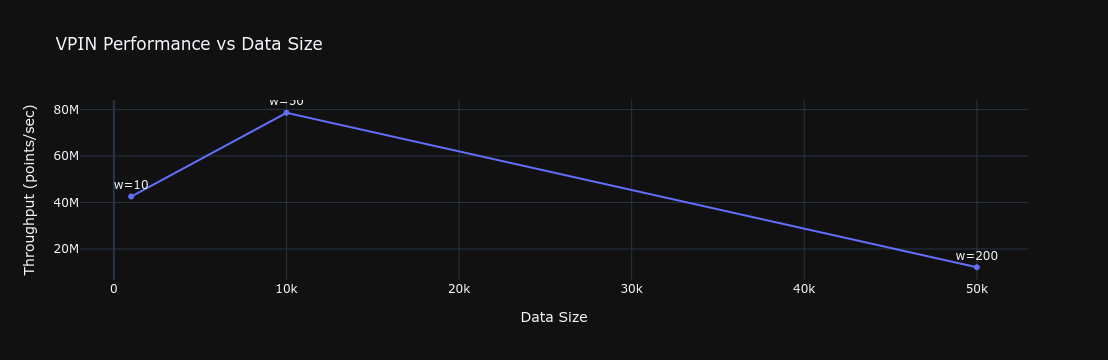

In [4]:
# Plot results
df = pd.DataFrame(results)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['size'], y=df['throughput'],
    mode='lines+markers+text',
    text=[f"w={w}" for w in df['window']],
    textposition="top center",
    name='Throughput'
))

fig.update_layout(
    title='VPIN Performance vs Data Size',
    xaxis_title='Data Size',
    yaxis_title='Throughput (points/sec)',
    template='plotly_dark'
)

fig.show()

In [5]:
# Summary
print("\n" + "="*40)
print("BENCHMARK SUMMARY")
print("="*40)
for r in results:
    print(f"Size {r['size']:6,}: {r['throughput']:8,.0f} pts/s")

avg_throughput = np.mean([r['throughput'] for r in results])
print(f"\nAverage: {avg_throughput:,.0f} points/sec")
print("="*40)


BENCHMARK SUMMARY
Size  1,000: 42,538,580 pts/s
Size 10,000: 78,633,371 pts/s
Size 50,000: 12,139,387 pts/s

Average: 44,437,113 points/sec
